In [26]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import gensim
import numpy as np
import nltk
import pandas as pd
import pyLDAvis.gensim
import pickle
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('wordnet')
np.random.seed(2018)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayushgarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
data = pd.read_parquet("./products.parquet.gz")

### Data Preprocessing

* Concatenate product name and description to include all information in one sentence
* Use gensim utils simple preprocessing to convert text to lowercase
* Remove stopwords from the text 
* Lemmatizing and stemming the final tokens

In [4]:
data['product_description'] = data['product_description'].fillna(value = "")

In [5]:
data["product_concat"] = data['product_name'] + data['product_description']

In [6]:
data

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,product_concat
0,0,0,w21z6tu,Cheese Tofu,,116,Cheese Tofu
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30,Naughty & Nice - SliceChocolate - Slice
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25,301. Pork Dumpling with Hot Chilli Vinaigrette...
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45,Mee KuahContain minced mutton meat
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24,Ham & Cheese Sandwich SetToasted to perfection...
...,...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,,22,Sriracha Chicken Whole Wheat Pita
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22,Dettol Liquid Hand wash Sensitive 250mlâ€¢ Det...
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22,Red Bean4 Pcs
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22,"Twister MealChoice of 1 Twister, 1 Hash Brown ..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633148 entries, 0 to 633147
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_id           633148 non-null  int64 
 1   vendor_id            633148 non-null  int64 
 2   vendor_geohash       633148 non-null  object
 3   product_name         633148 non-null  object
 4   product_description  633148 non-null  object
 5   order_count          633148 non-null  int64 
 6   product_concat       633148 non-null  object
dtypes: int64(3), object(4)
memory usage: 33.8+ MB


In [8]:
def lemmatize_stemming(text):
    porter = PorterStemmer()
    return porter.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [9]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [10]:
processed_docs = data['product_concat'].map(preprocess)

In [17]:
processed_docs

0                                             [chees, tofu]
1                       [naughti, nice, slicechocol, slice]
2            [pork, dumpl, chilli, vinaigrett, 红油抄手, spici]
3                         [kuahcontain, minc, mutton, meat]
4         [chees, sandwich, settoast, perfect, sandwich,...
                                ...                        
633143                     [sriracha, chicken, wheat, pita]
633144    [dettol, liquid, hand, wash, sensit, dettol, l...
633145                                               [bean]
633146    [twister, mealchoic, twister, hash, brown, cho...
633147                                  [chocol, croissant]
Name: product_concat, Length: 633148, dtype: object

In [13]:
pickle.dump(processed_docs, open( "processed_docs.p", "wb" ))

In [16]:
processed_docs = pickle.load(open("processed_docs.p", "rb"))

In [18]:
from wordcloud import WordCloud
all_word = []
for word in processed_docs:
    all_word.extend(word)
all_words = ''.join(all_word)

In [20]:
word_dict = Counter(all_word)

In [22]:
word_dict = dict(word_dict)

In [31]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate_from_frequencies(word_dict)

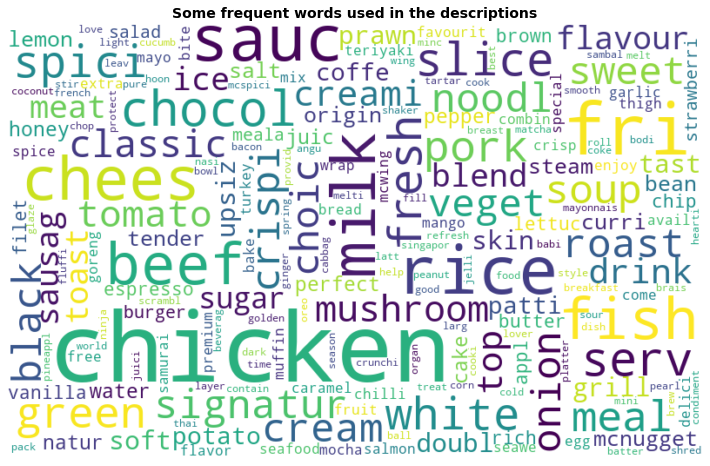

In [32]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the descriptions", weight='bold', fontsize=14)
plt.show()

### Modelisation
* Prepare dictionary of all the words in the text
* Filter out words from the dictionary that appear less than 15 times in the text and more than 50% of all texts
* Convert dictionary to bag of words
* Get tf-idf representation from bag of words
* Train LDA(Latent Dirichlet Allocation) model with 3 topics

In [12]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [13]:
len(dictionary)

63972

In [14]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=20000)

In [15]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [16]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [17]:
lda_model_3 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=3, workers=2)
for idx, topic in lda_model_3.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"green" + 0.011*"milk" + 0.011*"goreng" + 0.009*"honey" + 0.009*"bean" + 0.008*"thai" + 0.007*"chip" + 0.007*"lemon" + 0.007*"nasi" + 0.007*"sweet"
Topic: 1 
Words: 0.034*"chicken" + 0.030*"rice" + 0.027*"fri" + 0.016*"fish" + 0.014*"soup" + 0.014*"pork" + 0.014*"noodl" + 0.011*"beef" + 0.010*"chees" + 0.010*"sauc"
Topic: 2 
Words: 0.020*"chocol" + 0.019*"milk" + 0.011*"brown" + 0.011*"sugar" + 0.011*"salmon" + 0.010*"sausag" + 0.009*"coffe" + 0.009*"toast" + 0.007*"chicken" + 0.007*"pearl"


In [18]:
lda_display = pyLDAvis.gensim.prepare(lda_model_3, corpus_tfidf, dictionary, sort_topics=False)

In [19]:
pyLDAvis.display(lda_display)

### Model Inference on the original data

In [20]:
topics = []
scores = []

In [21]:
for scores_row in lda_model_3[corpus_tfidf]:
    sorted_row = sorted(scores_row, key=lambda tup: -1*tup[1])
    topics.append(sorted_row[0][0])
    scores.append(sorted_row[0][1])

In [22]:
processed_df = data.copy()
processed_df['topics'] = topics
processed_df['scores'] = scores

In [23]:
processed_df['topics'].value_counts()

1    268290
0    204870
2    159988
Name: topics, dtype: int64

In [24]:
processed_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,product_concat,topics,scores
0,0,0,w21z6tu,Cheese Tofu,,116,Cheese Tofu,1,0.712334
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30,Naughty & Nice - SliceChocolate - Slice,2,0.716760
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25,301. Pork Dumpling with Hot Chilli Vinaigrette...,1,0.587491
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45,Mee KuahContain minced mutton meat,1,0.524920
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24,Ham & Cheese Sandwich SetToasted to perfection...,2,0.470440
...,...,...,...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,,22,Sriracha Chicken Whole Wheat Pita,0,0.505678
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22,Dettol Liquid Hand wash Sensitive 250mlâ€¢ Det...,0,0.887905
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22,Red Bean4 Pcs,0,0.666612
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22,"Twister MealChoice of 1 Twister, 1 Hash Brown ...",0,0.600068


### Checking top products in each topic ordered by score

In [25]:
topic0 = processed_df.loc[processed_df['topics'] == 0].sort_values('scores', ascending = False)

In [26]:
topic1 = processed_df.loc[processed_df['topics'] == 1].sort_values('scores', ascending = False)

In [27]:
topic2 = processed_df.loc[processed_df['topics'] == 2].sort_values('scores', ascending = False)

In [28]:
topic0[:500]['product_name'].value_counts()

Guardian Baby Care Soft Wipes Fragrance Free, 3 x 90 sheets (600623) | 3x90 sheets       21
Guardian Baby Care Soft Wipes Chamomile Scented, 3 x 90 sheets (600624) | 3x90 sheets    20
Dettol Anti-Bacterial Surface Cleaner Spray 500ml                                        14
Enfagrow A+ Stage 3 Baby Formula Milk Powder 360DHA+ (1-3Y) 900g                         14
Dettol Liquid Antibacterial Hand wash Twinpack Refill - Sensitive 2s x 225ml             14
Dettol Liquid Hand Wash Strawberry 250ml                                                 14
Durex Play Classic Pleasure Gel 50ml                                                     14
Enfamil A+ Stage 2 Infant Formula Baby Milk Powder 360DHA+ (6M+) 900g                    14
Dettol Anti-Bacterial Body Wash Refill Lasting Fresh 900ml                               14
Dettol Anti-Bacterial Body Wash Refill Fresh 900ml                                       14
Enfagrow A+ Stage 3 Baby Formula Milk Powder 360DHA+ (1-3Y) 1.8KG               

In [34]:
topic1[:5000]['product_name'].value_counts()

Filet-O-Fish® Upsized Meal                                                                                                        816
Ninja Chicken Upsized Meal                                                                                                        803
Buttermilk Crispy Chicken Upsized Meal                                                                                            684
Ninja Chicken Meal                                                                                                                606
Buttermilk Crispy Chicken Meal                                                                                                    520
Buttermilk Crispy Chicken                                                                                                         310
Roasted Chicken Sub                                                                                                               300
Roasted Chicken Wrap                                          

In [38]:
topic2[:10000]['product_name'].value_counts()

Apple Pie                                                                      1006
Breakfast Wrap Sausage Meal                                                     855
Breakfast Deluxe™ Meal                                                          847
OREO® McFlurry®                                                                 837
Mudpie McFlurry®                                                                644
McWings® (4pc) Upsized Meal                                                     621
McWings® (4pc) Meal                                                             527
Breakfast Wrap Chicken Ham Meal                                                 388
Breakfast Wrap Sausage                                                          337
Iced Caffe Latte                                                                312
McCafé Mocha Frappe Medium                                                      298
Breakfast Wrap Chicken Ham                                                  

### Inference
* Topic 0 mostly contains medicines and daily groceries
* Topic 1 mostly contains main course food items including local Singaporean foods
* Topic 2 mostly contains Macdonald's items and drinks

In [39]:
grouped_processed = processed_df.groupby(['vendor_geohash', 'topics']).agg({'product_name': 'count'})
grouped_pcts = grouped_processed.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [40]:
grouped_pcts = grouped_pcts.reset_index()

In [41]:
grouped_pcts

,vendor_geohash,topics,product_name
0,ttsg7zf,1,100.000000
1,w21xjy4,1,100.000000
2,w21xpjq,0,46.511628
3,w21xpjq,1,27.906977
4,w21xpjq,2,25.581395
...,...,...,...
7137,w23bhd6,1,73.333333
7138,w23bhd6,2,13.333333
7139,w23bhdd,0,56.563366
7140,w23bhdd,1,13.731418


In [42]:
pivoted = grouped_pcts.pivot(index='vendor_geohash', columns='topics', values='product_name')

In [50]:
pivoted = pivoted.fillna(0.0)

In [72]:
pivoted.columns = ['T0: Daily Use Items' , 'T1: Main Course', 'T2: McDonalds and drinks']

In [73]:
pivoted

,T0: Daily Use Items,T1: Main Course,T2: McDonalds and drinks
vendor_geohash,,,
ttsg7zf,0.000000,100.000000,0.000000
w21xjy4,0.000000,100.000000,0.000000
w21xpjq,46.511628,27.906977,25.581395
w21xpr4,19.230769,30.769231,50.000000
w21xqws,100.000000,0.000000,0.000000
...,...,...,...
w23bh2w,17.647059,36.601307,45.751634
w23bh2y,18.000000,78.000000,4.000000
w23bh39,24.545455,57.272727,18.181818


In [70]:
processed_df = processed_df.merge(pivoted, on = 'vendor_geohash')

In [74]:
processed_df.sort_values('product_id')

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,product_concat,topics,scores,Daily Use Items,Main Course,McDonalds and drinks
0,0,0,w21z6tu,Cheese Tofu,,116,Cheese Tofu,1,0.712334,28.571429,52.040816,19.387755
196,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30,Naughty & Nice - SliceChocolate - Slice,2,0.716760,34.696017,30.712788,34.591195
1150,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25,301. Pork Dumpling with Hot Chilli Vinaigrette...,1,0.587491,29.741379,48.833671,21.424949
5094,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45,Mee KuahContain minced mutton meat,1,0.524920,26.303855,64.399093,9.297052
5535,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24,Ham & Cheese Sandwich SetToasted to perfection...,2,0.470440,32.055556,40.333333,27.611111
...,...,...,...,...,...,...,...,...,...,...,...,...
237887,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,,22,Sriracha Chicken Whole Wheat Pita,0,0.505678,36.557060,29.142489,34.300451
37249,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22,Dettol Liquid Hand wash Sensitive 250mlâ€¢ Det...,0,0.887905,56.080627,14.624860,29.294513
355940,633145,4135,w21ztw0,Red Bean,4 Pcs,22,Red Bean4 Pcs,0,0.666612,30.596285,31.182796,38.220919
448421,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22,"Twister MealChoice of 1 Twister, 1 Hash Brown ...",0,0.600068,34.810811,42.594595,22.594595


In [20]:
from gensim.models import CoherenceModel


In [77]:
coherence_model_lda = CoherenceModel(model=lda_model_3, texts=processed_docs, dictionary=dictionary, coherence='c_v')

In [78]:
coherence_lda = coherence_model_lda.get_coherence()

In [79]:
coherence_lda

0.32536356547516576

### Selecting the appropriate number of topics

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=3, workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_docs, start=2, limit=25, step=5)

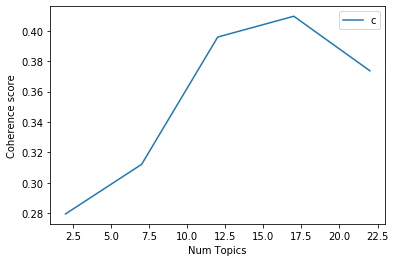

In [24]:
limit=25; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()